# Inverter Data

## Context
The data set comprises several sensor data collected from a typical combined system between an inverter, an induction motor, and a control system, deployed on a test bench. 
Test bench measurements were collected by the [LEA department at Paderborn University](https://ei.uni-paderborn.de/en/lea).

An inverter is a power electronic component with transistors (read 'switches'), that determine how the battery voltage (so called DC-link voltage) is applied on the three phase circuits of the electric motor.
The control unit decides according to some control strategy the current switching states of the inverter at each discrete point in time.

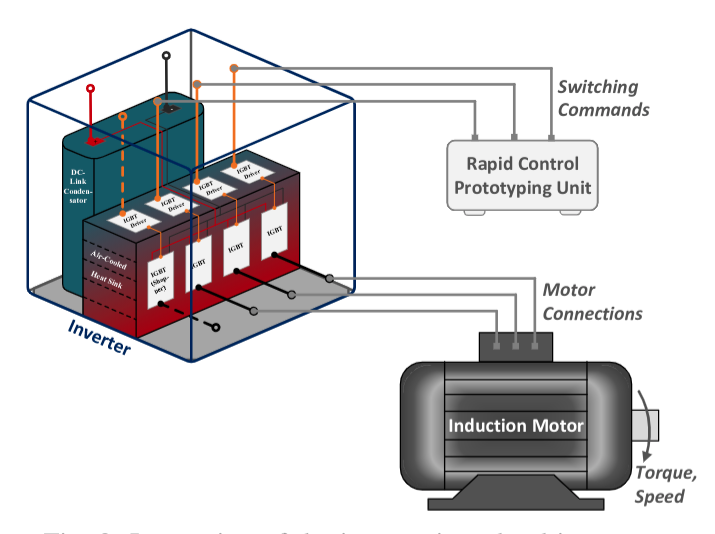

## Content
The data set comprises approximately 235 thousand samples in the complete operating range of an exemplary drive system.

Rows follow no particular order.


## Inspiration
The most important aspect of an electric vehicle from a marketing and engineering perspective is its efficiency and, thus, achievable range.
For this, it is essential to avoid over-dimensioning of the drive train, i.e. applying more and heavier metal packs to increase its thermal capabilities.
If the motor is controlled inefficiently through the inverter, there'll be superfluous power losses, i.e. heat build-up, which eventually leads to electric power derating during operation and, crucially, early depletion of the battery.

Precise phase voltage information is mandatory in order to enable an accurate, efficient or high dynamic control performance of electric motor drives, especially if a torque-controlled operation is considered. However, most electrical drives do not measure the phase voltages online due to their cost implications, and, therefore, these have to be estimated by inverter models. 

Because of various nonlinear switching effects partly at nanosecond scale, an analytical white-box modeling approach is hardly feasible in a control context. 
Hence, data-driven inverter models seem favorable for this purpose.

Since the control utilizes [pulse width modulation (PWM)](https://en.wikipedia.org/wiki/Pulse-width_modulation#:~:text=Pulse%2Dwidth%20modulation%20(PWM),it%20up%20into%20discrete%20parts.), the mean phase voltages for each PWM interval are the targets of the inverter models.

![tesla](https://images.unsplash.com/photo-1537988489137-33d67a16f3ec?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1489&q=80)
_(Image Source: [Unsplash.com](https://unsplash.com/photos/87royqk4t6o))_

See [this paper](https://www.researchgate.net/publication/343480544_Data_Set_Description_Three-Phase_IGBT_Two-Level_Inverter_for_Electrical_Drives) for a detailed research background.

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

plt.style.use('bmh')

In [ ]:
df = pd.read_csv('../input/inverter-data-set/Inverter Data Set.csv')
df.shape

In [ ]:
df.head()

In [ ]:
df.describe()

All variables are continuous and vary significantly in their value range as they pose different units.

Each variable comes with a sub-index k which indicates the point in time: k at present, k-1 the sampling step before that, and so on.

Let's group the variables in time:

In [ ]:
print('Variables at time k:')
print(sorted([c for c in df if c.endswith('k')]))
print('\nVariables at time k-1:')
print(sorted([c for c in df if c.endswith('k-1')]))
print('\nVariables at time k-2:')
print(sorted([c for c in df if c.endswith('k-2')]))
print('\nVariables at time k-3:')
print(sorted([c for c in df if c.endswith('k-3')]))


In general, four consecutive time steps are captured per row, but not each variable is present at each time step.

Particularly, motor speed __n_k__ is only present at _k_, while phase voltages __u_a/b/c__ are only present at _k-1_.
Moreover, duty cycles __d_a/b/c__ appear only in the first time steps _k-3_ and _k-2_.

Present in all time steps are the phase currents __i_a/b/c__ and the DC-link voltage __u_dc__.

## Modeling tasks
There are two potential modeling problems that this data set poses:

1. Inverter modeling:
    Targets: Phase voltages __u_a/b/c__ at time _k-1_, Inputs: All remaining features
2. Inverter compensation scheme:
    Targets: duty cycles __d_a/b/c__ at time _k-2_, Inputs: all remaining features
    
    
## Linear correlations

In [ ]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(14,14))
_ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We see strong linear correlation between the same signals across the time domain, as expected, while there is zero correlation between the motor speed and all currents, phase voltages, and duty cycles. Same goes for the DC-link voltage and all other signals.

Only the DC-link voltage to its own past values or to the motor speed show some correlation.

## Distributions

In [ ]:
dfui = df  # dataframe under investigation
# prepare colors
color_list = plt.cm.tab10(np.tile(np.linspace(0, 1, 10), dfui.shape[1])[:dfui.shape[1]])
coi = dfui.columns.tolist()  # columns of interest
feat_clrs = {k: rgb2hex(color_list[i][:3]) for i, k in enumerate(coi)} if color_list is not None else {}

n_cols = 7
n_rows = np.ceil(dfui.shape[1] / n_cols).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.8*n_cols, n_rows*3))
for i, (ax, col) in enumerate(zip(axes.flatten(), list(dfui.columns))):
    sns.distplot(dfui[col], color=feat_clrs[col], ax=ax)
    if i % n_cols == 0:
        ax.set_ylabel('Frequency')
plt.tight_layout()

We find:
* n_k follows around three certain values most of the time,
* All signals exhibit the same distribution as their past counterparts,
* __u_dc__ is bi-modal,
* phase currents __i_a/b/c__ seem to be pretty gaussian except for three spikes near the center,
* duty cycles __d_a/b/c__ and phase voltages __u_a/b/c__ follow a very similar distribution of symmetrical shape, whereas it is not quite gaussian,
* there are neglectable differences between the phases a/b/c.


## Time correlation
Let's explore the scatter between consecutive signals.

In [ ]:
n_rows = 1

def plot_scatter_consecutively(coi):
    fig, axes = plt.subplots(n_rows, len(coi)-1, sharey=True, sharex=True, figsize=(2.8*(len(coi)-1), n_rows*3))
    if len(coi)-1 > 1:
        for i, (ax, c) in enumerate(zip(axes.flatten(), coi[1:]), start=1):
            ax.scatter(df[c], df[coi[i-1]], s=.5)
            ax.set_xlabel(c)
            ax.set_ylabel(coi[i-1])
    else:
        axes.scatter(df[coi[1]], df[coi[0]], s=.5)
        axes.set_xlabel(coi[1])
        axes.set_ylabel(coi[0])
    fig.tight_layout()

col_ids = ['u_dc', 'i_a', 'i_b', 'i_c', 'd_a', 'd_b', 'd_c', 'u_a', 'u_b', 'u_c']
cols_d = {k: [c for c in df if c.startswith(k)] for k in col_ids}

for k, l in cols_d.items():
    if len(l) > 1:
        plot_scatter_consecutively(sorted(l))

As expected, the linear correlation is significant between consecutive signals. For the duty cycle it is less strong.

Let's have a look at the phase currents given the duty cyle.

In [ ]:
x_cols = [c for c in df if c.startswith('d_') and c.endswith('k-2')]
y_cols = [c for c in df if c.startswith('i_') and c.endswith(('k-2', 'k-1'))]
fig, axes = plt.subplots(2*n_rows, len(x_cols), sharey=True, sharex=True, figsize=(2.8*len(x_cols), n_rows*3*2))
for i, (ax, (c_x, c_y)) in enumerate(zip(axes.flatten(), zip(2*x_cols, y_cols))):
    ax.scatter(df[c_x], df[c_y], s=.5)
    if i // len(x_cols) >= 1:
        ax.set_xlabel(c_x)
    ax.set_ylabel(c_y)

fig.tight_layout()

A slight positive linear correlation is visible.


## Time series
Let's explore the time trajectory of the current signals, for which the most consecutive values per row are available.**

In [ ]:
current_cols_d = {k: v for k, v in cols_d.items() if k.startswith('i_')}
dfui = df.sample(1000)  # 1000 random samples
fig, axes = plt.subplots(n_rows, len(current_cols_d), sharey=True, sharex=True, figsize=(2.8*len(current_cols_d), n_rows*3))

for i, (ax, (c_id, c_l)) in enumerate(zip(axes.flatten(), current_cols_d.items())):
    
    ax.plot(dfui.loc[:, reversed(c_l)].T)
    ax.set_title(c_id)
    ax.set_xlabel('time')
    ax.set_xticklabels([c.split('_')[-1] for c in reversed(c_l)])
    if i == 0:
        ax.set_ylabel('currents in A')
fig.tight_layout()


The high time correlation becomes clear also in these plots. The signals are sampled with $10$ kHz after all.
An automatic matching algorithm might find order in the rows to exhibit the three phase sinusoidal signals.

## Feature Engineering

Utilizing the fact that the three phases always inherit a 120° phase shift, we can condense the phases a/b/c into two: $\alpha$/$\beta$.
This procedure is also known as the [Clarke-transformation](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_transformation).

In [ ]:
transformed_currents_d = {}
clarke_transform_matrix = 2/3 * np.array([[1, -0.5, -0.5],
                                         [0, np.sqrt(3)/2, -np.sqrt(3)/2],
                                         [0.5, 0.5, 0.5]])
for k in ['k', 'k-1', 'k-2', 'k-3']:
    cols = [c for c in df if c.startswith('i_') and c.endswith(k)]
    phase_currents = df[cols]
    assert phase_currents.shape[1] == 3
    transformed_currents =  np.dot(clarke_transform_matrix,  
                                   phase_currents.T.values)[:-1, :].T  # clarke transform
    transformed_currents_d[f'i_alpha_{k}'] = transformed_currents[:, 0]
    transformed_currents_d[f'i_beta_{k}'] = transformed_currents[:, 1]
df = df.assign(**transformed_currents_d)

In [ ]:
dfui = df[[c for c in df if 'beta' in c or 'alpha' in c]]
n_cols = 8
n_rows = np.ceil(dfui.shape[1] / n_cols).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.8*n_cols, n_rows*3))
for i, (ax, col) in enumerate(zip(axes.flatten(), list(dfui.columns))):
    sns.distplot(dfui[col], ax=ax)
    if i % n_cols == 0:
        ax.set_ylabel('Frequency')
plt.tight_layout()

In [ ]:
time_steps = ['k', 'k-1', 'k-2', 'k-3']
n_cols = len(time_steps)
n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.8*n_cols, n_rows*3))
for i, (ax, k) in enumerate(zip(axes.flatten(), time_steps)):
    x_col = f'i_alpha_{k}'
    y_col = f'i_beta_{k}'
    ax.scatter(df[x_col], df[y_col], s=0.5)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'time step {k}')

plt.tight_layout()

The cycling trajectories are characteristic for three-phase currents in stator-fixed coordinates that $alpha$ and $beta$ are.

The same can be repeated for the phase voltages and the phase duty cycles. No information is lost during these transformations

### Current $alpha$/$beta$ heat map

Brighter areas are visited more often.

In [ ]:
# heat map
N_BINS = 100
coi = [c for c in df if 'alpha' in c or 'beta' in c]
dfui = df.assign(**{f'binned_{c}': pd.cut(df[c].values.ravel(), bins=N_BINS, include_lowest=True)
                   for c in coi})
ts_map = {}
for k in time_steps:
    
    ts_map[k] = dfui.loc[:, [f'binned_i_alpha_{k}', f'binned_i_beta_{k}', 'i_beta_k']]\
                .groupby([f'binned_i_alpha_{k}', f'binned_i_beta_{k}']).count().fillna(0).reset_index()\
                .rename(columns={'i_beta_k': 'count'})\
                .pivot(index=f'binned_i_beta_{k}', columns=f'binned_i_alpha_{k}', values='count')\
                .sort_values(f'binned_i_beta_{k}', ascending=False)
    
n_cols = len(time_steps)
n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, n_rows*6))
for i, (ax, k) in enumerate(zip(axes.flatten(), time_steps)):
    sns.heatmap(ts_map[k], robust=True, square=True, yticklabels=49, xticklabels=49, cbar=False, ax=ax)
    x_col = f'i_alpha_{k}'
    y_col = f'i_beta_{k}'
    ax.set_xlabel(x_col+' normalized')
    ax.set_ylabel(y_col+' normalized')
    _ = ax.set_xticklabels([-1, 0, 1], rotation=0)
    _ = ax.set_yticklabels([1, 0, -1])
    ax.set_title(f'time step {k}')

fig.tight_layout()


It is slightly evident that currents tend to run on the six edges of a hexagon.
This is reasonable due to the [inverter voltage limits that can be reached at each phase which are shifted by 120°](https://www.switchcraft.org/learning/2017/3/15/space-vector-pwm-intro).